# Übung 4

## 1) Klassifikation mit SVMs

In [8]:
import pandas as pd
import numpy as np
import matplotlib as mp
import skimage
import scipy as sp
from sklearn import datasets, svm, model_selection
#from sklearn.model_selection import train_test_split

### 1a) Laden der Daten und Beschreibung

In [2]:
digits = datasets.load_digits()

In [3]:
digits.DESCR

"Optical Recognition of Handwritten Digits Data Set\n===================================================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 5620\n    :Number of Attributes: 64\n    :Attribute Information: 8x8 image of integer pixels in the range 0..16.\n    :Missing Attribute Values: None\n    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)\n    :Date: July; 1998\n\nThis is a copy of the test set of the UCI ML hand-written digits datasets\nhttp://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits\n\nThe data set contains images of hand-written digits: 10 classes where\neach class refers to a digit.\n\nPreprocessing programs made available by NIST were used to extract\nnormalized bitmaps of handwritten digits from a preprinted form. From a\ntotal of 43 people, 30 contributed to the training set and different 13\nto the test set. 32x32 bitmaps are divided into nonoverlapping blocks of\n4x4 and the number of on pixels are counted 

Die Merkmalsvektoren (hier Bilder) sind die Zeilen der Designmatrix digits.data. Zusammenstellung einer Zufallsauswahl von 10 Bildern:

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


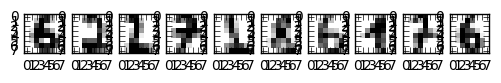

In [4]:
import random
%matplotlib inline
fig = mp.pyplot.figure()
indexes = random.sample(range(0, len(digits.target)), 10)
images = []
for i, index in zip(range(1, 11), indexes):
    mp.pyplot.subplot(1, 10, i)
    mp.pyplot.imshow(digits.images[index], cmap=mp.pyplot.cm.gray_r, interpolation='nearest')
    images.append((digits.target[index],digits.data[index])) #(label, image)

mp.pyplot.show()

Anzahl Bilder:

In [5]:
digits.target.shape

(1797,)

Dimension der Bilder:

In [6]:
digits.images[0].shape, digits.data[0].shape

((8, 8), (64,))

### 1b)

Teilen Sie den Datensatz zufällig in einen nichtüberlappenden Trainings- und Testdatensatz auf, so dass ein Viertel der Daten zu Testdaten werden. Dies geschieht am Einfachsten mit der Funktion sklearn.model_selection.train_test_split()

In [23]:
training_data, test_data, training_label, test_label = model_selection.train_test_split(digits.data, digits.target, test_size=0.25)
test_data.shape, test_label.shape, training_data.shape, training_label.shape

((450, 64), (450,), (1347, 64), (1347,))

Trainieren Sie einen Supportvektor-Klassifikator (Standard in Scikit Learn ist eine 1-Norm Soft Margin SVM, bei Mehrklassenproblemen wird automatisch ein Satz von one-vs.-one-Klassifikatoren erstellt) mit einem RBF-Kern mit γ = 0.015 und einem Parameter C = 1.0.

In [24]:
clf = svm.SVC(gamma=0.015, C=1.0)
clf.fit(training_data, training_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.015, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Bestimmen Sie den Anteil korrekt klassifizierter Beispiele (Korrektklassifikationsrate, Treffergenauigkeit, engl. Accuracy) im Trainings- und Testdatensatz mithilfe der Funktion SVC.score(). Underfitting liegt vor, wenn Ihr Klassifikator auf den Trainingsdatensatz eine Treffergenauigkeit von deutlich unter 100% erzielt, bei Overfitting liegt die Treffergenauigkeit auf dem Testdatensatz deutlich unter der auf dem Trainingsdatensatz. Welcher Fall liegt hier vor?

In [32]:
expected = test_label
predicted = clf.predict(test_data)

print(clf.score(test_data, test_label))
clf.score(training_data, training_label)
#expected, predicted

0.335555555556


1.0

Es handelt sich hierbei um Overfitting. 1.0 > 0.33

Probieren Sie alternativ die SVM-Parameter γ = 0.001 und C = 100 und vergleichen Sie.

In [33]:
clf = svm.SVC(gamma=0.001, C=100)
clf.fit(training_data, training_label)

print(clf.score(test_data, test_label))
clf.score(training_data, training_label)

0.997777777778


1.0

Wiederholen
Sie das Experiment für einen anderen Zufallssplit in Trainings- und Testdatensatz.

In [45]:
r_training_data, r_test_data, r_training_label, r_test_label = model_selection.train_test_split(digits.data, digits.target, test_size=0.99)

clf = svm.SVC(gamma=0.001, C=100)
clf.fit(r_training_data, r_training_label)

print(clf.score(r_test_data, r_test_label))
clf.score(r_training_data, r_training_label)

0.55393258427


1.0

Wie stark hängt Ihr Ergebnis von der zufälligen Teilung in Trainings- und Testdatensatz ab?

Es hängt sehr wenig davon ab, da schon wenige Trainingsdaten für ein gutes Ergebnis reichen.

## 2) Kreuzvalidierung und Modellselektion

### 2a)

## Konfiguration

In [ ]:
%load_ext version_information
%version_information numpy, pandas, matplotlib, skimage, sklearn